loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


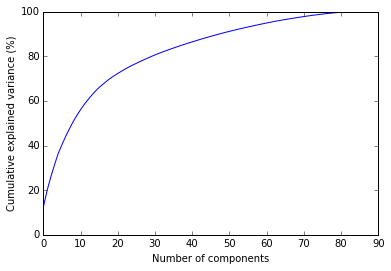

In [51]:
import numpy as np

from msmbuilder.example_datasets import FsPeptide
fs = FsPeptide().get()

from msmbuilder.featurizer import DihedralFeaturizer
dhf = DihedralFeaturizer()
dhft = dhf.fit_transform(fs.trajectories)

from sklearn.decomposition import PCA
pca = PCA(whiten=True)
pca.fit(np.vstack(dhft))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(100*np.cumsum(pca.explained_variance_ratio_))
plt.hlines(100.0,0,pca.n_components_,linestyles='--')
plt.ylim(0,100)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance (%)')

#n_comp = sum(np.cumsum(pca.explained_variance_ratio_)<0.95)

#X_ = pca.transform(np.vstack(dhft))[:,:n_comp]

X_ = np.vstack(dhft)
X_ -= X_.mean(0)
X_ /= X_.std(0)
X_train_ = X_[:200000]
X_test_ = X_[200000:]

#npr.seed(0)
#mask = npr.rand(len(X_))<0.7
#X_train_ = X_[mask]
#X_test_ = X_[-mask]

In [53]:
print('The first 2 components only explain {0:.2f}% of the variance'.format(100*np.cumsum(pca.explained_variance_ratio_)[1]))

The first 2 components only explain 19.97% of the variance


In [6]:
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.datasets import imdb

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas 

In [12]:
from keras.layers.recurrent import LSTM

lstm= LSTM(10, output_dim=128, 
        init='glorot_uniform', inner_init='orthogonal', 
        activation='tanh', inner_activation='hard_sigmoid',
        weights=None, truncate_gradient=-1, return_sequences=False)

In [14]:
model = Sequential()
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 1))
model.add(Activation('sigmoid'))

In [16]:
imdb_data = imdb.load_data()

In [22]:
X_[0].shape,np.hstack(X_[:2]).shape

((85,), (170,))

In [7]:
sequence.skipgrams(X_[:100],10)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [94]:
def generate_skip_gram_couples(sequences,neighborhood_size=10,n_examples=100000,prop_positive=0.5):
    np.random.seed(0)
    couples = np.zeros((n_examples,2*sequences[0].shape[1]))
    y = np.zeros((n_examples,2))
    
    for i in range(n_examples):
        ind1=np.random.randint(len(sequences))
        sequence = sequences[ind1]
        pivot = np.random.randint(len(sequence)-neighborhood_size)
        if np.random.rand()<prop_positive:
            label=1
            other = np.random.randint(neighborhood_size)+pivot
            couples[i] = np.hstack((sequence[pivot],sequence[other]))
        else:
            label=0
            ind2 = np.random.randint(len(sequences))
            sequence2 = sequences[ind2]
            other = np.random.randint(len(sequence))
            while ind1==ind2 and abs(other-pivot) < neighborhood_size:
                ind2 = np.random.randint(len(sequences))
                sequence2 = sequences[ind2]
                other = np.random.randint(len(sequence2))
            couples[i] = np.hstack((sequence[pivot],sequence2[other]))
                
        
        y[i,label] = 1
    return couples,y

In [95]:
X,y=generate_skip_gram_couples(dhft)

In [96]:
np.random.seed(0)
mask = np.random.rand(len(X))<0.7
X_train,y_train = X[mask],y[mask]
X_test,y_test = X[-mask],y[-mask]

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


In [97]:
X.shape,y.shape

((100000, 168), (100000, 2))

In [98]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(200, 50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50, 2))
model.add(Activation('relu'))
model.add(Dense(2, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.1353 - acc.: 0.7947 - val. loss: 0.0215 - val. acc.: 0.9753
Epoch 1
6s - loss: 0.0331 - acc.: 0.9599 - val. loss: 0.0215 - val. acc.: 0.9741
Epoch 2
6s - loss: 0.0274 - acc.: 0.9665 - val. loss: 0.0181 - val. acc.: 0.9781
Epoch 3
6s - loss: 0.0254 - acc.: 0.9695 - val. loss: 0.0177 - val. acc.: 0.9787
Epoch 4
6s - loss: 0.0237 - acc.: 0.9717 - val. loss: 0.0172 - val. acc.: 0.9803
Epoch 5
6s - loss: 0.0221 - acc.: 0.9739 - val. loss: 0.0176 - val. acc.: 0.9794
Epoch 6
7s - loss: 0.0211 - acc.: 0.9755 - val. loss: 0.0162 - val. acc.: 0.9812
Epoch 7
7s - loss: 0.0200 - acc.: 0.9765 - val. loss: 0.0162 - val. acc.: 0.9815
Epoch 8
7s - loss: 0.0198 - acc.: 0.9766 - val. loss: 0.0163 - val. acc.: 0.9810
Epoch 9
7s - loss: 0.0197 - acc.: 0.9770 - val. loss: 0.0161 - val. acc.: 0.9815


In [99]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(200, 50))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(50, 2))
model.add(Activation('tanh'))
model.add(Dense(2, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.2487 - acc.: 0.5182 - val. loss: 0.2237 - val. acc.: 0.6411
Epoch 1
5s - loss: 0.1315 - acc.: 0.8085 - val. loss: 0.0386 - val. acc.: 0.9587
Epoch 2
5s - loss: 0.0681 - acc.: 0.9099 - val. loss: 0.0323 - val. acc.: 0.9583
Epoch 3
5s - loss: 0.0532 - acc.: 0.9315 - val. loss: 0.0245 - val. acc.: 0.9697
Epoch 4
5s - loss: 0.0446 - acc.: 0.9436 - val. loss: 0.0254 - val. acc.: 0.9686
Epoch 5
5s - loss: 0.0405 - acc.: 0.9489 - val. loss: 0.0276 - val. acc.: 0.9661
Epoch 6
5s - loss: 0.0377 - acc.: 0.9532 - val. loss: 0.0221 - val. acc.: 0.9736
Epoch 7
5s - loss: 0.0354 - acc.: 0.9566 - val. loss: 0.0240 - val. acc.: 0.9717
Epoch 8
5s - loss: 0.0335 - acc.: 0.9586 - val. loss: 0.0221 - val. acc.: 0.9741
Epoch 9
5s - loss: 0.0316 - acc.: 0.9612 - val. loss: 0.0238 - val. acc.: 0.9720


In [100]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(200, 50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

In [101]:
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.0903 - acc.: 0.9001 - val. loss: 0.0263 - val. acc.: 0.9767
Epoch 1
7s - loss: 0.0429 - acc.: 0.9654 - val. loss: 0.0203 - val. acc.: 0.9782
Epoch 2
8s - loss: 0.0388 - acc.: 0.9714 - val. loss: 0.0209 - val. acc.: 0.9786
Epoch 3
9s - loss: 0.0371 - acc.: 0.9734 - val. loss: 0.0188 - val. acc.: 0.9796
Epoch 4
10s - loss: 0.0353 - acc.: 0.9751 - val. loss: 0.0184 - val. acc.: 0.9798
Epoch 5
10s - loss: 0.0349 - acc.: 0.9768 - val. loss: 0.0198 - val. acc.: 0.9796
Epoch 6
11s - loss: 0.0349 - acc.: 0.9769 - val. loss: 0.0187 - val. acc.: 0.9804
Epoch 7
11s - loss: 0.0340 - acc.: 0.9775 - val. loss: 0.0184 - val. acc.: 0.9805
Epoch 8
11s - loss: 0.0337 - acc.: 0.9786 - val. loss: 0.0180 - val. acc.: 0.9816
Epoch 9
12s - loss: 0.0333 - acc.: 0.9790 - val. loss: 0.0183 - val. acc.: 0.9811


In [102]:
model = Sequential()
model.add(Dense(168, 2))
model.add(Activation('linear'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
0s - loss: 0.2661 - acc.: 0.5008 - val. loss: 0.2558 - val. acc.: 0.4905
Epoch 1
0s - loss: 0.2599 - acc.: 0.5004 - val. loss: 0.2539 - val. acc.: 0.4992
Epoch 2
0s - loss: 0.2597 - acc.: 0.5023 - val. loss: 0.2570 - val. acc.: 0.5035
Epoch 3
0s - loss: 0.2599 - acc.: 0.5001 - val. loss: 0.2555 - val. acc.: 0.4793
Epoch 4
0s - loss: 0.2594 - acc.: 0.5049 - val. loss: 0.2549 - val. acc.: 0.4809
Epoch 5
0s - loss: 0.2596 - acc.: 0.5018 - val. loss: 0.2552 - val. acc.: 0.5011
Epoch 6
0s - loss: 0.2594 - acc.: 0.5021 - val. loss: 0.2564 - val. acc.: 0.4884
Epoch 7
0s - loss: 0.2595 - acc.: 0.5024 - val. loss: 0.2548 - val. acc.: 0.5143
Epoch 8
0s - loss: 0.2597 - acc.: 0.5016 - val. loss: 0.2698 - val. acc.: 0.4870
Epoch 9
0s - loss: 0.2596 - acc.: 0.4987 - val. loss: 0.3171 - val. acc.: 0.4941


In [103]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(200, 50))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(50, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.1662 - acc.: 0.7579 - val. loss: 0.0544 - val. acc.: 0.9499
Epoch 1
5s - loss: 0.0770 - acc.: 0.9102 - val. loss: 0.0323 - val. acc.: 0.9600
Epoch 2
5s - loss: 0.0576 - acc.: 0.9350 - val. loss: 0.0318 - val. acc.: 0.9587
Epoch 3
5s - loss: 0.0486 - acc.: 0.9460 - val. loss: 0.0239 - val. acc.: 0.9716
Epoch 4
5s - loss: 0.0441 - acc.: 0.9523 - val. loss: 0.0226 - val. acc.: 0.9756
Epoch 5
5s - loss: 0.0401 - acc.: 0.9574 - val. loss: 0.0221 - val. acc.: 0.9733
Epoch 6
5s - loss: 0.0383 - acc.: 0.9597 - val. loss: 0.0185 - val. acc.: 0.9781
Epoch 7
5s - loss: 0.0359 - acc.: 0.9623 - val. loss: 0.0194 - val. acc.: 0.9766
Epoch 8
5s - loss: 0.0343 - acc.: 0.9643 - val. loss: 0.0183 - val. acc.: 0.9779
Epoch 9
5s - loss: 0.0334 - acc.: 0.9651 - val. loss: 0.0188 - val. acc.: 0.9771


In [104]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(200, 50))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(50, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.0583 - acc.: 0.9424 - val. loss: 0.0219 - val. acc.: 0.9779
Epoch 1
5s - loss: 0.0257 - acc.: 0.9774 - val. loss: 0.0182 - val. acc.: 0.9793
Epoch 2
6s - loss: 0.0227 - acc.: 0.9802 - val. loss: 0.0178 - val. acc.: 0.9793
Epoch 3
7s - loss: 0.0210 - acc.: 0.9817 - val. loss: 0.0196 - val. acc.: 0.9796
Epoch 4
7s - loss: 0.0199 - acc.: 0.9830 - val. loss: 0.0173 - val. acc.: 0.9801
Epoch 5
8s - loss: 0.0194 - acc.: 0.9839 - val. loss: 0.0170 - val. acc.: 0.9811
Epoch 6
8s - loss: 0.0189 - acc.: 0.9842 - val. loss: 0.0169 - val. acc.: 0.9804
Epoch 7
8s - loss: 0.0185 - acc.: 0.9844 - val. loss: 0.0172 - val. acc.: 0.9812
Epoch 8
9s - loss: 0.0181 - acc.: 0.9853 - val. loss: 0.0168 - val. acc.: 0.9808
Epoch 9
9s - loss: 0.0180 - acc.: 0.9853 - val. loss: 0.0182 - val. acc.: 0.9804


In [105]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(200, 5))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(5, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
4s - loss: 0.0891 - acc.: 0.9075 - val. loss: 0.0300 - val. acc.: 0.9777
Epoch 1
5s - loss: 0.0548 - acc.: 0.9570 - val. loss: 0.0252 - val. acc.: 0.9784
Epoch 2
6s - loss: 0.0508 - acc.: 0.9604 - val. loss: 0.0253 - val. acc.: 0.9781
Epoch 3
6s - loss: 0.0492 - acc.: 0.9616 - val. loss: 0.0253 - val. acc.: 0.9818
Epoch 4
7s - loss: 0.0483 - acc.: 0.9624 - val. loss: 0.0229 - val. acc.: 0.9815
Epoch 5
7s - loss: 0.0476 - acc.: 0.9624 - val. loss: 0.0229 - val. acc.: 0.9818
Epoch 6
8s - loss: 0.0478 - acc.: 0.9626 - val. loss: 0.0226 - val. acc.: 0.9816
Epoch 7
8s - loss: 0.0465 - acc.: 0.9651 - val. loss: 0.0215 - val. acc.: 0.9827
Epoch 8
9s - loss: 0.0464 - acc.: 0.9643 - val. loss: 0.0234 - val. acc.: 0.9823
Epoch 9
9s - loss: 0.0464 - acc.: 0.9643 - val. loss: 0.0223 - val. acc.: 0.9821


In [106]:
model = Sequential()
model.add(Dense(168, 100))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(100, 2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
3s - loss: 0.1178 - acc.: 0.8238 - val. loss: 0.0342 - val. acc.: 0.9782
Epoch 1
2s - loss: 0.0765 - acc.: 0.8785 - val. loss: 0.0355 - val. acc.: 0.9766
Epoch 2
3s - loss: 0.0730 - acc.: 0.8818 - val. loss: 0.0375 - val. acc.: 0.9808
Epoch 3
2s - loss: 0.0707 - acc.: 0.8852 - val. loss: 0.0298 - val. acc.: 0.9802
Epoch 4
3s - loss: 0.0706 - acc.: 0.8837 - val. loss: 0.0323 - val. acc.: 0.9806
Epoch 5
3s - loss: 0.0693 - acc.: 0.8866 - val. loss: 0.0303 - val. acc.: 0.9809
Epoch 6
2s - loss: 0.0696 - acc.: 0.8838 - val. loss: 0.0322 - val. acc.: 0.9819
Epoch 7
2s - loss: 0.0692 - acc.: 0.8849 - val. loss: 0.0308 - val. acc.: 0.9820
Epoch 8
3s - loss: 0.0683 - acc.: 0.8870 - val. loss: 0.0313 - val. acc.: 0.9827
Epoch 9
3s - loss: 0.0694 - acc.: 0.8845 - val. loss: 0.0299 - val. acc.: 0.9824


In [107]:
model = Sequential()
model.add(Dense(168, 2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
0s - loss: 0.3168 - acc.: 0.5020 - val. loss: 0.2655 - val. acc.: 0.5186
Epoch 1
0s - loss: 0.3086 - acc.: 0.4999 - val. loss: 0.2632 - val. acc.: 0.5210
Epoch 2
0s - loss: 0.3080 - acc.: 0.5003 - val. loss: 0.2715 - val. acc.: 0.4776
Epoch 3
0s - loss: 0.3091 - acc.: 0.4999 - val. loss: 0.2824 - val. acc.: 0.4882
Epoch 4
0s - loss: 0.3088 - acc.: 0.5025 - val. loss: 0.2701 - val. acc.: 0.4901
Epoch 5
0s - loss: 0.3084 - acc.: 0.5016 - val. loss: 0.2681 - val. acc.: 0.5093
Epoch 6
0s - loss: 0.3079 - acc.: 0.5021 - val. loss: 0.2623 - val. acc.: 0.5080
Epoch 7
0s - loss: 0.3084 - acc.: 0.5007 - val. loss: 0.2697 - val. acc.: 0.4952
Epoch 8
0s - loss: 0.3076 - acc.: 0.5043 - val. loss: 0.2671 - val. acc.: 0.4947
Epoch 9
0s - loss: 0.3086 - acc.: 0.5003 - val. loss: 0.2667 - val. acc.: 0.5022


In [108]:
model = Sequential()
model.add(Dense(168, 300))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(300, 2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
6s - loss: 0.1077 - acc.: 0.8823 - val. loss: 0.0289 - val. acc.: 0.9744
Epoch 1
9s - loss: 0.0704 - acc.: 0.9381 - val. loss: 0.0304 - val. acc.: 0.9783
Epoch 2
10s - loss: 0.0663 - acc.: 0.9496 - val. loss: 0.0296 - val. acc.: 0.9790
Epoch 3
13s - loss: 0.0651 - acc.: 0.9519 - val. loss: 0.0314 - val. acc.: 0.9783
Epoch 4
14s - loss: 0.0640 - acc.: 0.9558 - val. loss: 0.0264 - val. acc.: 0.9799
Epoch 5
15s - loss: 0.0639 - acc.: 0.9568 - val. loss: 0.0250 - val. acc.: 0.9810
Epoch 6
16s - loss: 0.0632 - acc.: 0.9583 - val. loss: 0.0237 - val. acc.: 0.9803
Epoch 7
16s - loss: 0.0617 - acc.: 0.9606 - val. loss: 0.0268 - val. acc.: 0.9802
Epoch 8
17s - loss: 0.0616 - acc.: 0.9601 - val. loss: 0.0257 - val. acc.: 0.9810
Epoch 9
17s - loss: 0.0617 - acc.: 0.9615 - val. loss: 0.0250 - val. acc.: 0.9807


In [109]:
def generate_kinetic_distance_pairs(sequences,max_kinetic_distance=1000,n_examples=100000):
    np.random.seed(0)
    pairs = np.zeros((n_examples,2*sequences[0].shape[1]))
    y = np.zeros((n_examples))
    
    for i in range(n_examples):
        sequence = sequences[np.random.randint(len(sequences))]
        pivot = np.random.randint(len(sequence)-max_kinetic_distance)
        kinetic_distance = np.random.randint(1,max_kinetic_distance)
        other = pivot + kinetic_distance
        
        pairs[i] = np.hstack((sequence[pivot],sequence[other]))
        y[i] = kinetic_distance
    y -= y.mean()
    y /= y.std()
    return pairs,y

In [110]:
X,y = generate_kinetic_distance_pairs(dhft)
np.random.seed(0)
mask = np.random.rand(len(X))<0.7
X_train,y_train = X[mask],y[mask]
X_test,y_test = X[-mask],y[-mask]

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


In [111]:
model = Sequential()
model.add(Dense(168, 1))
model.add(Activation('linear'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=20, nb_epoch=20, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
0s - loss: 1.0210 - acc.: 1.0000 - val. loss: 1.0087 - val. acc.: 1.0000
Epoch 1
0s - loss: 1.0072 - acc.: 1.0000 - val. loss: 1.0117 - val. acc.: 1.0000
Epoch 2
0s - loss: 1.0060 - acc.: 1.0000 - val. loss: 1.0095 - val. acc.: 1.0000
Epoch 3
0s - loss: 1.0057 - acc.: 1.0000 - val. loss: 1.0038 - val. acc.: 1.0000
Epoch 4
0s - loss: 1.0061 - acc.: 1.0000 - val. loss: 1.0204 - val. acc.: 1.0000
Epoch 5
0s - loss: 1.0065 - acc.: 1.0000 - val. loss: 1.0047 - val. acc.: 1.0000
Epoch 6
0s - loss: 1.0054 - acc.: 1.0000 - val. loss: 1.0054 - val. acc.: 1.0000
Epoch 7
0s - loss: 1.0060 - acc.: 1.0000 - val. loss: 1.0044 - val. acc.: 1.0000
Epoch 8
0s - loss: 1.0053 - acc.: 1.0000 - val. loss: 1.0094 - val. acc.: 1.0000
Epoch 9
0s - loss: 1.0055 - acc.: 1.0000 - val. loss: 1.0095 - val. acc.: 1.0000
Epoch 10
0s - loss: 1.0053 - acc.: 1.0000 - val. loss: 1.0109 - val. acc.: 1.0000
Epoch 11
0s - loss: 1.0053 - acc.: 1.0000 - val. loss: 1.0

30021/30021 [==============================] - 0s     


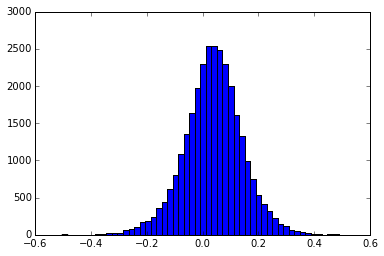

In [113]:
y_pred = model.predict(X_test)
plt.hist(y_pred,bins=50);

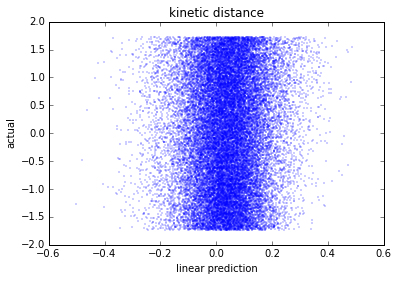

In [116]:
plt.scatter(y_pred,y_test,linewidths=0,alpha=0.5,s=2)
plt.xlabel('linear prediction')
plt.ylabel('actual')
plt.title('kinetic distance')

In [72]:
model = Sequential()
model.add(Dense(168, 300))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(300, 20))
model.add(Activation('relu'))
model.add(Dense(20, 1))
model.add(Activation('relu'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=20, nb_epoch=20, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
10s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 1
12s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 2
6s - loss: 0.9986 - acc.: 1.0000 - val. loss: 1.0030 - val. acc.: 1.0000
Epoch 3
6s - loss: 0.9981 - acc.: 1.0000 - val. loss: 1.0024 - val. acc.: 1.0000
Epoch 4
6s - loss: 0.9978 - acc.: 1.0000 - val. loss: 1.0020 - val. acc.: 1.0000
Epoch 5
4s - loss: 0.9973 - acc.: 1.0000 - val. loss: 1.0013 - val. acc.: 1.0000
Epoch 6
4s - loss: 0.9951 - acc.: 1.0000 - val. loss: 0.9912 - val. acc.: 1.0000
Epoch 7
4s - loss: 0.9854 - acc.: 1.0000 - val. loss: 0.9948 - val. acc.: 1.0000
Epoch 8
4s - loss: 0.9785 - acc.: 1.0000 - val. loss: 0.9775 - val. acc.: 1.0000
Epoch 9
4s - loss: 0.9711 - acc.: 1.0000 - val. loss: 0.9735 - val. acc.: 1.0000
Epoch 10
4s - loss: 0.9657 - acc.: 1.0000 - val. loss: 0.9698 - val. acc.: 1.0000
Epoch 11
4s - loss: 0.9615 - acc.: 1.0000 - val. loss: 0

In [75]:
model = Sequential()
model.add(Dense(168, 100))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, 10))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(10, 1))
model.add(Activation('tanh'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=20, nb_epoch=20, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
1s - loss: 1.0072 - acc.: 1.0000 - val. loss: 1.0052 - val. acc.: 1.0000
Epoch 1
1s - loss: 0.9923 - acc.: 1.0000 - val. loss: 0.9821 - val. acc.: 1.0000
Epoch 2
1s - loss: 0.9635 - acc.: 1.0000 - val. loss: 0.9385 - val. acc.: 1.0000
Epoch 3
1s - loss: 0.9378 - acc.: 1.0000 - val. loss: 0.9150 - val. acc.: 1.0000
Epoch 4
1s - loss: 0.9131 - acc.: 1.0000 - val. loss: 0.8782 - val. acc.: 1.0000
Epoch 5
1s - loss: 0.8918 - acc.: 1.0000 - val. loss: 0.8647 - val. acc.: 1.0000
Epoch 6
1s - loss: 0.8760 - acc.: 1.0000 - val. loss: 0.8358 - val. acc.: 1.0000
Epoch 7
1s - loss: 0.8623 - acc.: 1.0000 - val. loss: 0.8310 - val. acc.: 1.0000
Epoch 8
1s - loss: 0.8535 - acc.: 1.0000 - val. loss: 0.8250 - val. acc.: 1.0000
Epoch 9
1s - loss: 0.8409 - acc.: 1.0000 - val. loss: 0.8285 - val. acc.: 1.0000
Epoch 10
1s - loss: 0.8318 - acc.: 1.0000 - val. loss: 0.8104 - val. acc.: 1.0000
Epoch 11
1s - loss: 0.8230 - acc.: 1.0000 - val. loss: 0.7

In [76]:
model = Sequential()
model.add(Dense(168, 200))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(200, 20))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(20, 1))
model.add(Activation('tanh'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=20, nb_epoch=20, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
2s - loss: 1.0047 - acc.: 1.0000 - val. loss: 0.9856 - val. acc.: 1.0000
Epoch 1
2s - loss: 0.9645 - acc.: 1.0000 - val. loss: 0.9390 - val. acc.: 1.0000
Epoch 2
3s - loss: 0.9356 - acc.: 1.0000 - val. loss: 0.9191 - val. acc.: 1.0000
Epoch 3
3s - loss: 0.9149 - acc.: 1.0000 - val. loss: 0.8959 - val. acc.: 1.0000
Epoch 4
2s - loss: 0.9004 - acc.: 1.0000 - val. loss: 0.8763 - val. acc.: 1.0000
Epoch 5
2s - loss: 0.8832 - acc.: 1.0000 - val. loss: 0.8776 - val. acc.: 1.0000
Epoch 6
3s - loss: 0.8730 - acc.: 1.0000 - val. loss: 0.8699 - val. acc.: 1.0000
Epoch 7
3s - loss: 0.8616 - acc.: 1.0000 - val. loss: 0.8459 - val. acc.: 1.0000
Epoch 8
2s - loss: 0.8500 - acc.: 1.0000 - val. loss: 0.8286 - val. acc.: 1.0000
Epoch 9
2s - loss: 0.8393 - acc.: 1.0000 - val. loss: 0.8303 - val. acc.: 1.0000
Epoch 10
2s - loss: 0.8316 - acc.: 1.0000 - val. loss: 0.8164 - val. acc.: 1.0000
Epoch 11
2s - loss: 0.8216 - acc.: 1.0000 - val. loss: 0.8

In [125]:
model = Sequential()
model.add(Dense(168, 168))
model.add(Activation('tanh'))
model.add(Dense(168, 500))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(500, 50))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(50, 1))
model.add(Activation('tanh'))

rms = RMSprop()
model.compile(loss='mae', optimizer=rms)
model.fit(X_train, y_train, batch_size=50, nb_epoch=100, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.8681 - acc.: 1.0000 - val. loss: 0.8684 - val. acc.: 1.0000
Epoch 1
5s - loss: 0.8656 - acc.: 1.0000 - val. loss: 0.8703 - val. acc.: 1.0000
Epoch 2
5s - loss: 0.8653 - acc.: 1.0000 - val. loss: 0.8694 - val. acc.: 1.0000
Epoch 3
5s - loss: 0.8640 - acc.: 1.0000 - val. loss: 0.8654 - val. acc.: 1.0000
Epoch 4
5s - loss: 0.8563 - acc.: 1.0000 - val. loss: 0.8462 - val. acc.: 1.0000
Epoch 5
5s - loss: 0.8388 - acc.: 1.0000 - val. loss: 0.8487 - val. acc.: 1.0000
Epoch 6
5s - loss: 0.8233 - acc.: 1.0000 - val. loss: 0.8104 - val. acc.: 1.0000
Epoch 7
5s - loss: 0.8103 - acc.: 1.0000 - val. loss: 0.8015 - val. acc.: 1.0000
Epoch 8
5s - loss: 0.7966 - acc.: 1.0000 - val. loss: 0.7918 - val. acc.: 1.0000
Epoch 9
5s - loss: 0.7849 - acc.: 1.0000 - val. loss: 0.7739 - val. acc.: 1.0000
Epoch 10
5s - loss: 0.7751 - acc.: 1.0000 - val. loss: 0.7758 - val. acc.: 1.0000
Epoch 11
5s - loss: 0.7670 - acc.: 1.0000 - val. loss: 0.7

KeyboardInterrupt: 

30021/30021 [==============================] - 0s     


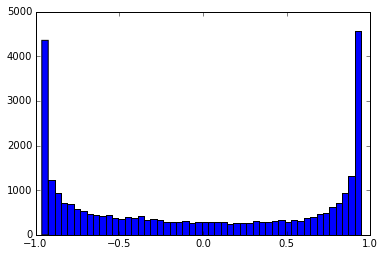

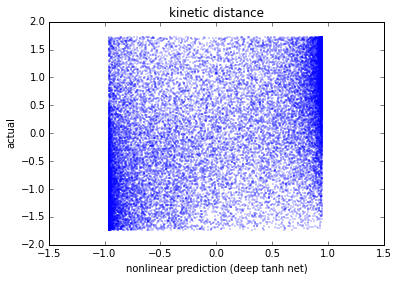

In [126]:
y_pred = model.predict(X_test)
plt.hist(y_pred,bins=50);

plt.figure()

plt.scatter(y_pred,y_test,linewidths=0,alpha=0.5,s=2)
plt.xlabel('nonlinear prediction (deep tanh net)')
plt.ylabel('actual')
plt.title('kinetic distance')

In [132]:
model_relu = Sequential()
model_relu.add(Dense(168, 300))
model_relu.add(Activation('relu'))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(300, 100))
model_relu.add(Activation('relu'))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(100, 50))
model_relu.add(Activation('relu'))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(50, 1))

rms = RMSprop()
model_relu.compile(loss='mae', optimizer=rms)
model_relu.fit(X_train, y_train, batch_size=50, nb_epoch=1000, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model_relu.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
3s - loss: 0.8661 - acc.: 1.0000 - val. loss: 0.8688 - val. acc.: 1.0000
Epoch 1
3s - loss: 0.8659 - acc.: 1.0000 - val. loss: 0.8688 - val. acc.: 1.0000
Epoch 2
3s - loss: 0.8657 - acc.: 1.0000 - val. loss: 0.8682 - val. acc.: 1.0000
Epoch 3
3s - loss: 0.8645 - acc.: 1.0000 - val. loss: 0.8647 - val. acc.: 1.0000
Epoch 4
3s - loss: 0.8553 - acc.: 1.0000 - val. loss: 0.8384 - val. acc.: 1.0000
Epoch 5
3s - loss: 0.8344 - acc.: 1.0000 - val. loss: 0.8112 - val. acc.: 1.0000
Epoch 6
3s - loss: 0.8168 - acc.: 1.0000 - val. loss: 0.7890 - val. acc.: 1.0000
Epoch 7
3s - loss: 0.8042 - acc.: 1.0000 - val. loss: 0.7849 - val. acc.: 1.0000
Epoch 8
3s - loss: 0.7938 - acc.: 1.0000 - val. loss: 0.7665 - val. acc.: 1.0000
Epoch 9
3s - loss: 0.7841 - acc.: 1.0000 - val. loss: 0.7545 - val. acc.: 1.0000
Epoch 10
3s - loss: 0.7775 - acc.: 1.0000 - val. loss: 0.7623 - val. acc.: 1.0000
Epoch 11
3s - loss: 0.7722 - acc.: 1.0000 - val. loss: 0.7

KeyboardInterrupt: 

30021/30021 [==============================] - 0s     


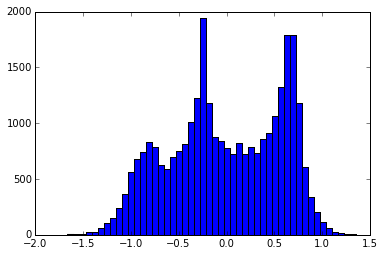

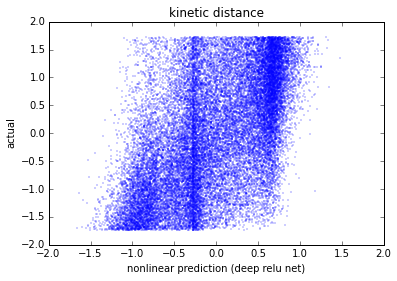

In [133]:
y_pred = model_relu.predict(X_test)
plt.hist(y_pred,bins=50);

plt.figure()

plt.scatter(y_pred,y_test,linewidths=0,alpha=0.5,s=2)
plt.xlabel('nonlinear prediction (deep relu net)')
plt.ylabel('actual')
plt.title('kinetic distance')

In [134]:
model_relu = Sequential()
model_relu.add(Dense(168, 500))
model_relu.add(Activation('relu'))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(500, 200))
model_relu.add(Activation('relu'))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(200, 50))
model_relu.add(Activation('relu'))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(50, 10))
model_relu.add(Activation('relu'))
model_relu.add(Dense(10, 1))

rms = RMSprop()
model_relu.compile(loss='mae', optimizer=rms)
model_relu.fit(X_train, y_train, batch_size=50, nb_epoch=1000, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model_relu.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
5s - loss: 0.8660 - acc.: 1.0000 - val. loss: 0.8687 - val. acc.: 1.0000
Epoch 1
5s - loss: 0.8659 - acc.: 1.0000 - val. loss: 0.8686 - val. acc.: 1.0000
Epoch 2
5s - loss: 0.8658 - acc.: 1.0000 - val. loss: 0.8687 - val. acc.: 1.0000
Epoch 3
5s - loss: 0.8653 - acc.: 1.0000 - val. loss: 0.8674 - val. acc.: 1.0000
Epoch 4
5s - loss: 0.8641 - acc.: 1.0000 - val. loss: 0.8632 - val. acc.: 1.0000
Epoch 5
5s - loss: 0.8577 - acc.: 1.0000 - val. loss: 0.8485 - val. acc.: 1.0000
Epoch 6
5s - loss: 0.8404 - acc.: 1.0000 - val. loss: 0.8155 - val. acc.: 1.0000
Epoch 7
5s - loss: 0.8185 - acc.: 1.0000 - val. loss: 0.7957 - val. acc.: 1.0000
Epoch 8
5s - loss: 0.8037 - acc.: 1.0000 - val. loss: 0.7788 - val. acc.: 1.0000
Epoch 9
5s - loss: 0.7913 - acc.: 1.0000 - val. loss: 0.7741 - val. acc.: 1.0000
Epoch 10
5s - loss: 0.7822 - acc.: 1.0000 - val. loss: 0.7642 - val. acc.: 1.0000
Epoch 11
5s - loss: 0.7743 - acc.: 1.0000 - val. loss: 0.7

30021/30021 [==============================] - 0s     


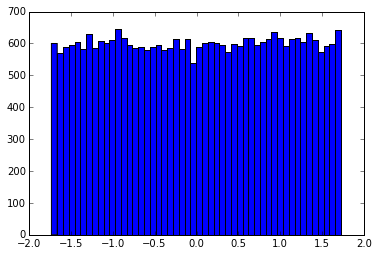

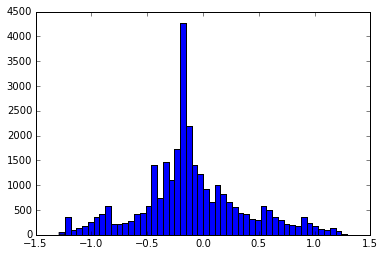

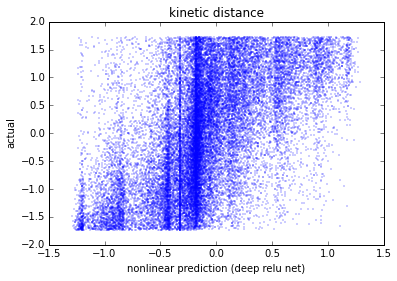

In [137]:
plt.hist(y_test,bins=50);
plt.figure('distribution of distances')

y_pred = model_relu.predict(X_test)
plt.hist(y_pred,bins=50);
plt.figure('distribution of predictions')

plt.figure()

plt.scatter(y_pred,y_test,linewidths=0,alpha=0.5,s=2)
plt.xlabel('nonlinear prediction (deep relu net)')
plt.ylabel('actual')
plt.title('kinetic distance')

In [80]:
model = Sequential()
model.add(Dense(168, 50))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(50, 1))
model.add(Activation('relu'))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=200, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
4s - loss: 0.9988 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 1
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 2
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 3
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 4
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 5
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 6
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 7
4s - loss: 0.9987 - acc.: 1.0000 - val. loss: 1.0031 - val. acc.: 1.0000
Epoch 8


KeyboardInterrupt: 

In [ ]:
# and how well can we do with just the aligned atomic distances?

In [140]:
from mdtraj.geometry import alignment

def compute_atomwise_deviation_xyz(X_xyz,Y_xyz):
    ''' given two sets of coordinates as numpy arrays,
    align them and return the vector of distances between
    corresponding pairs of atoms'''
    X_prime = alignment.transform(X_xyz, Y_xyz)
    delta = X_prime - Y_xyz
    deviation = ((delta**2).sum(1))**0.5
    return deviation

def compute_atomwise_deviation(X,Y):
    ''' given trajectory frames, compute atomwise deviations'''
    return compute_atomwise_deviation_xyz(X.xyz[0],Y.xyz[0])

In [143]:
fs.trajectories[0].n_atoms

264

In [150]:
def generate_skip_gram_deviations(sequences,neighborhood_size=10,n_examples=100000,prop_positive=0.5):
    np.random.seed(0)
    deviations = np.zeros((n_examples,sequences[0].n_atoms))
    y = np.zeros((n_examples,2))
    
    for i in range(n_examples):
        ind1=np.random.randint(len(sequences))
        sequence = sequences[ind1]
        pivot = np.random.randint(len(sequence)-neighborhood_size)
        if np.random.rand()<prop_positive:
            label=1
            other = np.random.randint(neighborhood_size)+pivot
            deviations[i] = compute_atomwise_deviation(sequence[pivot],sequence[other])
        else:
            label=0
            ind2 = np.random.randint(len(sequences))
            sequence2 = sequences[ind2]
            other = np.random.randint(len(sequence))
            while ind1==ind2 and abs(other-pivot) < neighborhood_size:
                ind2 = np.random.randint(len(sequences))
                sequence2 = sequences[ind2]
                other = np.random.randint(len(sequence2))
            deviations[i] = compute_atomwise_deviation(sequence[pivot],sequence2[other])
        
        if i % (n_examples / 50) == 0:
            print(i)
        
        y[i,label] = 1
    return deviations,y

In [155]:
X_deviations,y_dev = generate_skip_gram_deviations(fs.trajectories,n_examples=100000)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000


In [156]:
np.random.seed(0)
mask = np.random.rand(len(X_deviations))<0.7
X_train,y_train = X_deviations[mask],y_dev[mask]
X_test,y_test = X_deviations[-mask],y_dev[-mask]

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


In [157]:
n_atoms = len(X_train.T)

In [158]:
model = Sequential()
model.add(Dense(n_atoms, 100))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(100, 2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
4s - loss: 0.0821 - acc.: 0.8712 - val. loss: 0.0226 - val. acc.: 0.9856
Epoch 1
5s - loss: 0.0621 - acc.: 0.8854 - val. loss: 0.0203 - val. acc.: 0.9866
Epoch 2
5s - loss: 0.0605 - acc.: 0.8873 - val. loss: 0.0238 - val. acc.: 0.9823
Epoch 3
6s - loss: 0.0605 - acc.: 0.8896 - val. loss: 0.0218 - val. acc.: 0.9841
Epoch 4
6s - loss: 0.0601 - acc.: 0.8878 - val. loss: 0.0197 - val. acc.: 0.9869
Epoch 5
6s - loss: 0.0603 - acc.: 0.8872 - val. loss: 0.0219 - val. acc.: 0.9849
Epoch 6
6s - loss: 0.0604 - acc.: 0.8882 - val. loss: 0.0205 - val. acc.: 0.9866
Epoch 7
6s - loss: 0.0605 - acc.: 0.8870 - val. loss: 0.0209 - val. acc.: 0.9859
Epoch 8
6s - loss: 0.0602 - acc.: 0.8881 - val. loss: 0.0232 - val. acc.: 0.9824
Epoch 9
6s - loss: 0.0595 - acc.: 0.8890 - val. loss: 0.0233 - val. acc.: 0.9831


In [159]:
model = Sequential()
model.add(Dense(n_atoms, 100))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, 2))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(2, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
3s - loss: 0.0539 - acc.: 0.9524 - val. loss: 0.0199 - val. acc.: 0.9791
Epoch 1
3s - loss: 0.0402 - acc.: 0.9625 - val. loss: 0.0139 - val. acc.: 0.9864
Epoch 2
3s - loss: 0.0386 - acc.: 0.9653 - val. loss: 0.0137 - val. acc.: 0.9867
Epoch 3
3s - loss: 0.0380 - acc.: 0.9663 - val. loss: 0.0135 - val. acc.: 0.9868
Epoch 4
3s - loss: 0.0380 - acc.: 0.9660 - val. loss: 0.0133 - val. acc.: 0.9879
Epoch 5
3s - loss: 0.0378 - acc.: 0.9675 - val. loss: 0.0146 - val. acc.: 0.9858
Epoch 6
3s - loss: 0.0378 - acc.: 0.9657 - val. loss: 0.0131 - val. acc.: 0.9877
Epoch 7
3s - loss: 0.0379 - acc.: 0.9667 - val. loss: 0.0130 - val. acc.: 0.9879
Epoch 8
3s - loss: 0.0374 - acc.: 0.9673 - val. loss: 0.0239 - val. acc.: 0.9720
Epoch 9
3s - loss: 0.0369 - acc.: 0.9680 - val. loss: 0.0126 - val. acc.: 0.9887


In [215]:
model = Sequential()
model.add(Dense(n_atoms, 2))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, y_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=False, verbose=0)

Train on 69979 samples, validate on 30021 samples
Epoch 0
0s - loss: 0.0542 - acc.: 0.9654 - val. loss: 0.0380 - val. acc.: 0.9820
Epoch 1
0s - loss: 0.0376 - acc.: 0.9782 - val. loss: 0.0321 - val. acc.: 0.9800
Epoch 2
0s - loss: 0.0364 - acc.: 0.9789 - val. loss: 0.0342 - val. acc.: 0.9832
Epoch 3
0s - loss: 0.0357 - acc.: 0.9800 - val. loss: 0.0312 - val. acc.: 0.9788
Epoch 4
0s - loss: 0.0352 - acc.: 0.9806 - val. loss: 0.0305 - val. acc.: 0.9835
Epoch 5
0s - loss: 0.0350 - acc.: 0.9814 - val. loss: 0.0454 - val. acc.: 0.9704
Epoch 6
0s - loss: 0.0347 - acc.: 0.9818 - val. loss: 0.0301 - val. acc.: 0.9824
Epoch 7
0s - loss: 0.0345 - acc.: 0.9820 - val. loss: 0.0348 - val. acc.: 0.9791
Epoch 8
0s - loss: 0.0344 - acc.: 0.9818 - val. loss: 0.0394 - val. acc.: 0.9768
Epoch 9
0s - loss: 0.0344 - acc.: 0.9819 - val. loss: 0.0483 - val. acc.: 0.9856


In [216]:
layer = model.layers[0]
weights = layer.W.get_value()

In [218]:
labels = (y_test*np.vstack((np.zeros(len(y_test)),np.ones(len(y_test)))).T).sum(1)

In [225]:
X_unsup = PCA(2).fit_transform(X_test)

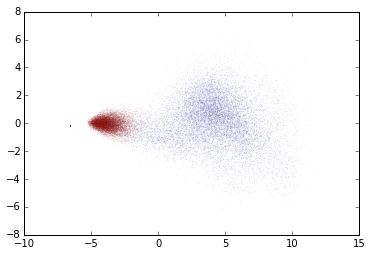

In [232]:
plt.scatter(X_unsup[:,0],X_unsup[:,1],s=1,alpha=0.1,linewidths=0,c=labels)

In [235]:
from sklearn.lda import LDA
lda = LDA(2)
X_sup = lda.fit_transform(X_test,labels)
X_sup.shape

(30021, 1)

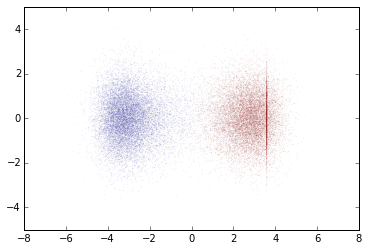

In [236]:
plt.scatter(X_sup,np.random.randn(len(X_sup)),s=1,alpha=0.1,linewidths=0,c=labels)

In [217]:
X_pred_lin = PCA(2).fit_transform(np.dot(X_test,weights))

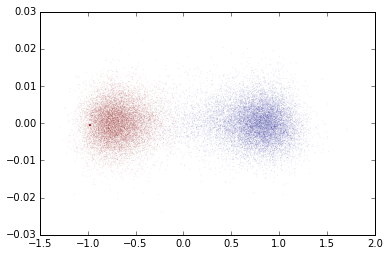

In [219]:
plt.scatter(X_pred_lin[:,0],X_pred_lin[:,1],s=1,alpha=0.1,linewidths=0,c=labels)

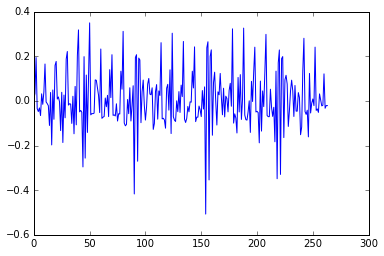

In [223]:
plt.plot(weights[:,0])

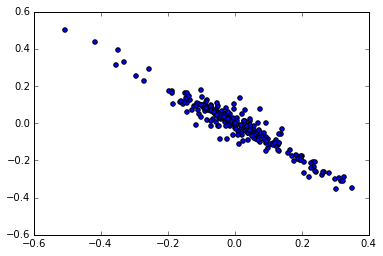

In [224]:
plt.scatter(weights[:,0],weights[:,1])

In [239]:
from msmbuilder.featurizer import RawPositionsFeaturizer
rpft = RawPositionsFeaturizer().fit_transform(fs.trajectories)

In [245]:
X = np.vstack(rpft)

In [247]:
X.shape

(280000, 792)

In [248]:
np.random.seed(0)
mask = np.random.rand(len(X))<0.7
X_train = X[mask]
X_test = X[-mask]

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


In [250]:
n_coords = X.shape[1]
model = Sequential()
model.add(Dense(n_coords, 2))
model.add(Dense(2, n_coords))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, X_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=False, verbose=0)

Train on 195989 samples, validate on 84011 samples
Epoch 0
6s - loss: 0.2381 - acc.: 0.0253 - val. loss: 0.2377 - val. acc.: 0.0270
Epoch 1
5s - loss: 0.2372 - acc.: 0.0267 - val. loss: 0.2378 - val. acc.: 0.0219
Epoch 2
5s - loss: 0.2372 - acc.: 0.0258 - val. loss: 0.2372 - val. acc.: 0.0289
Epoch 3
5s - loss: 0.2372 - acc.: 0.0268 - val. loss: 0.2382 - val. acc.: 0.0231
Epoch 4
5s - loss: 0.2372 - acc.: 0.0261 - val. loss: 0.2390 - val. acc.: 0.0200
Epoch 5
5s - loss: 0.2372 - acc.: 0.0259 - val. loss: 0.2371 - val. acc.: 0.0243
Epoch 6
5s - loss: 0.2372 - acc.: 0.0261 - val. loss: 0.2381 - val. acc.: 0.0221
Epoch 7
5s - loss: 0.2372 - acc.: 0.0262 - val. loss: 0.2372 - val. acc.: 0.0243
Epoch 8
5s - loss: 0.2372 - acc.: 0.0261 - val. loss: 0.2375 - val. acc.: 0.0251
Epoch 9
5s - loss: 0.2372 - acc.: 0.0253 - val. loss: 0.2374 - val. acc.: 0.0231


In [254]:
layer = model.layers[0]
weights = layer.W.get_value()

In [251]:
X_pca = PCA(2).fit_transform(X)

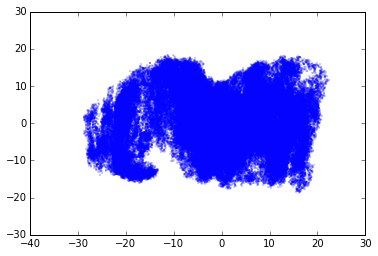

In [252]:
plt.scatter(X_pca[:,0],X_pca[:,1],linewidths=0,alpha=0.5,s=2)

In [255]:
X_nn_pca = np.dot(X,weights)

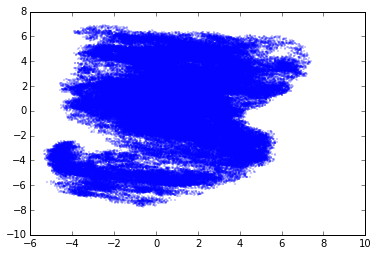

In [256]:
plt.scatter(X_nn_pca[:,0],X_nn_pca[:,1],linewidths=0,alpha=0.5,s=2)

In [ ]:
n_coords = X.shape[1]
model = Sequential()
model.add(Dense(n_coords, 2))

model.add(Dense(2, n_coords))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, X_train, batch_size=10, nb_epoch=10, show_accuracy=True, verbose=2, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=False, verbose=0)

In [258]:
n_coords = X.shape[1]
model = Sequential()
model.add(Dense(n_coords, 50))
model.add(Activation('tanh'))
model.add(Dense(50, 2))
model.add(Activation('tanh'))
model.add(Dense(2, 50))
model.add(Activation('tanh'))
model.add(Dense(50, n_coords))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, X_train, batch_size=10, nb_epoch=100, show_accuracy=True, verbose=2, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=False, verbose=0)

Train on 195989 samples, validate on 84011 samples
Epoch 0
23s - loss: 0.2399 - acc.: 0.0245 - val. loss: 0.2248 - val. acc.: 0.0307
Epoch 1
24s - loss: 0.2141 - acc.: 0.0277 - val. loss: 0.2070 - val. acc.: 0.0328
Epoch 2
24s - loss: 0.1996 - acc.: 0.0303 - val. loss: 0.1948 - val. acc.: 0.0424
Epoch 3
25s - loss: 0.1939 - acc.: 0.0367 - val. loss: 0.1938 - val. acc.: 0.0419
Epoch 4
24s - loss: 0.1910 - acc.: 0.0386 - val. loss: 0.1890 - val. acc.: 0.0368
Epoch 5
25s - loss: 0.1835 - acc.: 0.0395 - val. loss: 0.1842 - val. acc.: 0.0365
Epoch 6
25s - loss: 0.1829 - acc.: 0.0385 - val. loss: 0.1843 - val. acc.: 0.0413
Epoch 7
25s - loss: 0.1804 - acc.: 0.0365 - val. loss: 0.1786 - val. acc.: 0.0339
Epoch 8
24s - loss: 0.1795 - acc.: 0.0383 - val. loss: 0.1778 - val. acc.: 0.0363
Epoch 9
25s - loss: 0.1760 - acc.: 0.0415 - val. loss: 0.1745 - val. acc.: 0.0429
Epoch 10
26s - loss: 0.1767 - acc.: 0.0411 - val. loss: 0.1780 - val. acc.: 0.0419
Epoch 11
26s - loss: 0.1778 - acc.: 0.0407 - v

KeyboardInterrupt: 

In [277]:
layer1 = model.layers[0]
layer1_out = np.tanh(np.dot(X,layer1.W.get_value())+layer1.b.get_value())
layer2 = model.layers[2]
layer2_out = layer2.activation(np.dot(layer1_out,layer2.W.get_value())+layer2.b.get_value())
layer1_out.shape,layer2_out.shape

((280000, 50), (280000, 2))

In [278]:
X_nn = layer2_out

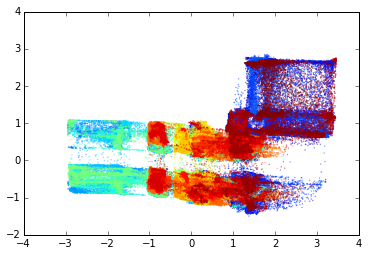

In [280]:
plt.scatter(X_nn[:,0],X_nn[:,1],linewidths=0,alpha=0.5,s=2,c=np.arange(len(X_nn)))

In [288]:
# now with dihedral angles instead

X = np.vstack(dhft)
np.random.seed(0)
mask = np.random.rand(len(X))<0.7
X_train = X[mask]
X_test = X[-mask]

n_coords = X.shape[1]
model = Sequential()
model.add(Dense(n_coords, 50))
model.add(Activation('tanh'))
model.add(Dense(50, 2))
model.add(Activation('tanh'))
model.add(Dense(2, 50))
model.add(Activation('tanh'))
model.add(Dense(50, n_coords))

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)
model.fit(X_train, X_train, batch_size=10, nb_epoch=100, show_accuracy=True, verbose=2, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=False, verbose=0)

Train on 195989 samples, validate on 84011 samples
Epoch 0
5s - loss: 0.1736 - acc.: 0.0593 - val. loss: 0.1675 - val. acc.: 0.0604
Epoch 1
5s - loss: 0.1608 - acc.: 0.0666 - val. loss: 0.1535 - val. acc.: 0.0675
Epoch 2
5s - loss: 0.1481 - acc.: 0.0537 - val. loss: 0.1432 - val. acc.: 0.0609
Epoch 3
5s - loss: 0.1412 - acc.: 0.0637 - val. loss: 0.1393 - val. acc.: 0.0643
Epoch 4
5s - loss: 0.1380 - acc.: 0.0664 - val. loss: 0.1363 - val. acc.: 0.0671
Epoch 5
5s - loss: 0.1341 - acc.: 0.0665 - val. loss: 0.1320 - val. acc.: 0.0674
Epoch 6
5s - loss: 0.1308 - acc.: 0.0684 - val. loss: 0.1303 - val. acc.: 0.0708
Epoch 7
5s - loss: 0.1294 - acc.: 0.0672 - val. loss: 0.1291 - val. acc.: 0.0586
Epoch 8
5s - loss: 0.1286 - acc.: 0.0697 - val. loss: 0.1286 - val. acc.: 0.0741
Epoch 9
5s - loss: 0.1278 - acc.: 0.0729 - val. loss: 0.1277 - val. acc.: 0.0624
Epoch 10
5s - loss: 0.1269 - acc.: 0.0750 - val. loss: 0.1263 - val. acc.: 0.0767
Epoch 11
5s - loss: 0.1259 - acc.: 0.0770 - val. loss: 0.

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


In [289]:
def partial_apply(model,X):
    layer1 = model.layers[0]
    layer1_out = np.tanh(np.dot(X,layer1.W.get_value())+layer1.b.get_value())
    layer2 = model.layers[2]
    layer2_out = layer2.activation(np.dot(layer1_out,layer2.W.get_value())+layer2.b.get_value())
    return layer2_out

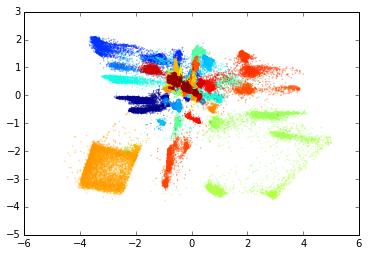

In [291]:
X_nn = partial_apply(model,X)
plt.scatter(X_nn[:,0],X_nn[:,1],linewidths=0,alpha=0.5,s=2,c=np.arange(len(X_nn)))

In [287]:
pca = PCA(2)
pca.fit(X)
np.sum((pca.inverse_transform(pca.transform(X))-X)**2)/(len(X)*X.shape[1])

0.17575058460884355

In [286]:
X.shape

(280000, 84)

In [282]:
dhft[0].shape

(10000, 84)

In [81]:
from msmbuilder.example_datasets import MetEnkephalin

In [82]:
met = MetEnkephalin().get()

In [84]:
print(met.DESCR)

The dataset consists of ten ~50 ns molecular dynamics (MD) simulation
trajectories of the 5 residue Met-enkaphalin peptide. The aggregate
sampling is 499.58 ns. Simulations were performed starting from the 1st
model in the 1PLX PDB file, solvated with 832 TIP3P water molecules using
OpenMM 6.0. The coordinates (protein only -- the water was stripped)
are saved every 5 picoseconds. Each of the ten trajectories is roughly
50 ns long and contains about 10,000 snapshots.

Forcefield: amber99sb-ildn; water: tip3p; nonbonded method: PME; cutoffs:
1nm; bonds to hydrogen were constrained; integrator: langevin dynamics;
temperature: 300K; friction coefficient: 1.0/ps; pressure control: Monte
Carlo barostat (interval of 25 steps); timestep 2 fs.

The dataset is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026324

